In [ ]:
import jax
import jax.numpy as jnp
from jax import value_and_grad
import matplotlib.pyplot as plt
import optax
import jax.random as random
from functools import partial


In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
def periodic_kernel(u, u_prime, period, length_scale=0.1):
    """
    Periodic kernel: k(u, u') = exp(-2 sin^2(\pi (u - u')/p) / l^2)

    u, u_prime: scalar values
    length_scale: controls smoothness
    period: periodicity of the function
    """
    diff = u - u_prime
    sin_term = jnp.sin(jnp.pi * diff / period)
    return jnp.exp(-2 * sin_term**2 / (length_scale**2))

def separable_periodic_kernel(x1, x2, period_x, period_t, length_scale_x, length_scale_t):
    """
    Separable kernel: k((x,t), (x',t')) = k_per(x, x') * k_per(t, t')

    x1, x2: arrays of shape (2,) where x1 = [x, t]
    Uses periodic kernel in x with given period
    Uses periodic kernel in t (but t may not be truly periodic)
    """
    x_kernel = periodic_kernel(x1[0], x2[0], period_x, length_scale_x)
    t_kernel = periodic_kernel(x1[1], x2[1], period_t, length_scale_t)
    return x_kernel * t_kernel

def build_kernel_matrix(points, period_x, period_t, length_scale_x=0.1, length_scale_t=0.1):
    """
    Build kernel matrix K where K[i,j] = k(points[i], points[j])
    points: (n, 2) array of (x, t) coordinates
    """
    n = points.shape[0]
    K = jnp.zeros((n, n))

    for i in range(n):
        for j in range(n):
            K = K.at[i, j].set(separable_periodic_kernel(points[i], points[j], period_x, period_t, length_scale_x, length_scale_t))

    return K

# Vectorized version for efficiency
@jax.jit
def build_kernel_matrix_vectorized(points, period_x, period_t, length_scale_x=0.1, length_scale_t=0.1):
    """Vectorized kernel matrix construction"""
    def compute_row(point):
        return jax.vmap(lambda p: separable_periodic_kernel(point, p, period_x, period_t, length_scale_x, length_scale_t))(points)

    return jax.vmap(compute_row)(points)

In [ ]:
def get_problems_1d(_x, _t, prob='exp_t'):
    """Generate true initial condition and forcing term for 1D"""
    _t_trunc = _t[1:][:, None]
    _x_trunc = _x[1:-1][None, :]

    if prob == 'exp_t':
        u0_true = jnp.sin(jnp.pi * _x[1:-1])
        term1 = (1 - 2 * _t_trunc + jnp.pi**2) * jnp.exp(_t_trunc**2)
        term2 = jnp.exp(-2*_t_trunc**2 + _t_trunc) * jnp.sin(jnp.pi * _x_trunc)
        f_true = term1 * term2

    elif prob == 'cossin':
        w = 10  # frequency parameter
        u0_true = jnp.sin(w * jnp.pi * _x[1:-1])
        term1 = w * jnp.pi * jnp.sin(w * jnp.pi * _x_trunc)
        term2 = w * jnp.pi * jnp.cos(w * jnp.pi * _t_trunc) - jnp.sin(w * jnp.pi * _t_trunc)
        f_true = (term1 * term2).squeeze()

    return u0_true, f_true

In [ ]:
def heat_solver_matrix_1d(n_x):
    """Create the 1D heat equation matrix"""
    h = 1.0 / (n_x - 1)
    n_inner = n_x - 2

    diag = jnp.ones(n_inner) * 2.0 / (h**2)
    off_diag = jnp.ones(n_inner - 1) * (-1.0 / (h**2))
    A = jnp.diag(diag) + jnp.diag(off_diag, 1) + jnp.diag(off_diag, -1)

    return A

@jax.jit
def crank_nicolson_step_1d(u, f_n, f_n1, A, k):
    """Crank-Nicolson step for 1D heat equation"""
    n = u.shape[0]
    I = jnp.eye(n)

    lhs_matrix = I + (k/2) * A
    rhs = (I - (k/2) * A) @ u + (k/2) * (f_n + f_n1)

    u_next = jnp.linalg.solve(lhs_matrix, rhs)
    return u_next

@jax.jit
def time_stepping_1d(u0, f, A, k):
    """Time stepping using Crank-Nicolson for 1D heat equation"""
    def body_fn(u_prev, carry):
        f_n, f_n1 = carry
        u_next = crank_nicolson_step_1d(u_prev, f_n, f_n1, A, k)
        return u_next, u_next

    _, us = jax.lax.scan(body_fn, u0, (f[:-1], f[1:]))
    return jnp.vstack([u0[None, :], us])

In [ ]:
# TODO: jit it and add static vars
def evaluate_rkhs_function(alpha, period_x, period_t, length_scale_x, length_scale_t, train_points, eval_points):
    """
    Evaluate f(x,t) = sum_i alpha_i * k((x,t), (x_i, t_i))

    alpha: (n,) coefficients
    train_points: (n, 2) training points (x_i, t_i)
    eval_points: (m, 2) evaluation points
    """
    def eval_single(eval_point):
        kernels = jax.vmap(lambda train_pt: separable_periodic_kernel(eval_point, train_pt, period_x, period_t, length_scale_x, length_scale_t))(train_points)
        return jnp.dot(alpha, kernels)

    return jax.vmap(eval_single)(eval_points)

In [ ]:
# TODO: jit it and add static vars
def loss_fn(alpha, period_x, period_t, length_scale_x, length_scale_t, train_points, K, eval_grid, u0_true, u_traj_true, A, k, n_t_eval, n_x_eval, lam=1e-3):
    """
    Loss function with RKHS regularization

    Loss = ||u_traj_true - u_guess||² + λ * ||f||_H²
    where ||f||_H² = α^T K α (by representer theorem)
    """
    # Evaluate forcing on the evaluation grid
    f_values = evaluate_rkhs_function(alpha, period_x, period_t, length_scale_x, length_scale_t, train_points, eval_grid)

    # Reshape to (n_t, n_x) where n_t = 100 (for t[1:])
    f_grid = f_values.reshape(n_t_eval, n_x_eval)

    # Solve PDE with f shape (100, 49) - no need to prepend zeros
    u_traj_guess = time_stepping_1d(u0_true, f_grid, A, k)

    # MSE loss
    mse = jnp.mean((u_traj_guess - u_traj_true)**2)

    # RKHS norm: ||f||_H² = α^T K α
    rkhs_norm = alpha @ K @ alpha

    total_loss = mse + lam * rkhs_norm

    return total_loss, {'mse': mse, 'rkhs': lam * rkhs_norm}


In [ ]:
# Grid parameters
n_x = 51  # More points for better resolution
n_t = 100

h = 1.0 / (n_x - 1)
t_final = 0.5
k = t_final / n_t

x = jnp.linspace(0, 1, n_x)
t = jnp.linspace(0, t_final, n_t + 1)

n_inner = n_x - 2

# Create system matrix
A = heat_solver_matrix_1d(n_x)

# Generate true solution
u0_true, f_true = get_problems_1d(x, t, prob='cossin')
u_traj_true = time_stepping_1d(u0_true, f_true, A, k)

print(f"f_true.shape = {f_true.shape}")
print(f"u0_true.shape = {u0_true.shape}")
print(f"u_traj_true.shape = {u_traj_true.shape}")


n_train_x = n_inner
n_train_t = n_t


x_train_idx = jnp.linspace(0, n_inner-1, n_train_x, dtype=int)
t_train_idx = jnp.linspace(0, n_t-1, n_train_t, dtype=int)

# Create training points grid
train_points = []
for t_idx in t_train_idx:
    for x_idx in x_train_idx:
        train_points.append([x[1:-1][x_idx], t[1:][t_idx]])

train_points = jnp.array(train_points)
n_train = train_points.shape[0]

print(f"Number of training points: {n_train}")
print(f"train_points.shape = {train_points.shape}")

f_true.shape = (100, 49)
u0_true.shape = (49,)
u_traj_true.shape = (100, 49)
Number of training points: 4900
train_points.shape = (4900, 2)


In [ ]:
period_x = 0.2 # TODO: make this learnable
period_t = 0.2 # TODO: make this learnable
length_scale_x = 0.15
length_scale_t = 0.15
# Build kernel matrix
print("Building kernel matrix...")

K = build_kernel_matrix_vectorized(train_points, period_x, period_t, length_scale_x, length_scale_t)
print(f"K.shape = {K.shape}")

# Create evaluation grid (all space-time points where we need f)
# We need f for t[1:] (excluding t=0), at all interior x points
eval_grid = []
for t_idx in range(n_t):  # This is for t[1:], so n_t points
    for x_idx in range(n_inner):
        eval_grid.append([x[1:-1][x_idx], t[1:][t_idx]])

eval_grid = jnp.array(eval_grid)
print(f"eval_grid.shape = {eval_grid.shape}")
print(f"Expected size: {n_t} * {n_inner} = {n_t * n_inner}")

Building kernel matrix...
K.shape = (4900, 4900)
eval_grid.shape = (4900, 2)
Expected size: 100 * 49 = 4900


In [ ]:
def train_rkhs(num_epochs=10000, lr=0.01, lam=1e-8):
    """Training loop for RKHS approach"""

    # Initialize coefficients alpha
    key = random.PRNGKey(0)
    alpha = random.normal(key, shape=(n_train,))

    # Setup optimizer
    opt = optax.adam(lr)
    opt_state = opt.init(alpha)

    losses = []

    # Create partial loss function
    loss_partial = partial(loss_fn,
                           period_x=period_x,
                           period_t=period_t,
                           length_scale_x=length_scale_x,
                           length_scale_t=length_scale_t,
                           train_points=train_points,
                           K=K,
                           eval_grid=eval_grid,
                           u0_true=u0_true,
                           u_traj_true=u_traj_true,
                           A=A,
                           k=k,
                           n_t_eval=n_t,
                           n_x_eval=n_inner,
                           lam=lam)


    for epoch in range(num_epochs):
        (loss, components), grad = value_and_grad(loss_partial, has_aux=True)(alpha)

        # Update step
        updates, opt_state = opt.update(grad, opt_state)
        alpha = optax.apply_updates(alpha, updates)

        losses.append(float(loss))

        if epoch % 300 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss:.6f}, MSE = {components['mse']:.6f}, RKHS norm = {components['rkhs']:.6f}")

    return alpha, losses

# Train the model
alpha_trained, losses = train_rkhs()

# Generate learned forcing
f_learned_values = evaluate_rkhs_function(alpha_trained, period_x, period_t, length_scale_x, length_scale_t, train_points, eval_grid)
f_learned = f_learned_values.reshape(n_t, n_inner)

Epoch 0: Total Loss = 0.274530, MSE = 0.274485, RKHS norm = 0.000046
Epoch 300: Total Loss = 0.226787, MSE = 0.223215, RKHS norm = 0.003572
Epoch 600: Total Loss = 0.193424, MSE = 0.178738, RKHS norm = 0.014687
Epoch 900: Total Loss = 0.175758, MSE = 0.147087, RKHS norm = 0.028671
Epoch 1200: Total Loss = 0.167543, MSE = 0.126183, RKHS norm = 0.041360
Epoch 1500: Total Loss = 0.164069, MSE = 0.113195, RKHS norm = 0.050874
Epoch 1800: Total Loss = 0.162702, MSE = 0.105586, RKHS norm = 0.057116
Epoch 2100: Total Loss = 0.162195, MSE = 0.101376, RKHS norm = 0.060820
Epoch 2400: Total Loss = 0.162019, MSE = 0.099170, RKHS norm = 0.062850
Epoch 2700: Total Loss = 0.161963, MSE = 0.098073, RKHS norm = 0.063890
Epoch 3000: Total Loss = 0.161947, MSE = 0.097558, RKHS norm = 0.064388
Epoch 3300: Total Loss = 0.161942, MSE = 0.097332, RKHS norm = 0.064610
Epoch 3600: Total Loss = 0.161941, MSE = 0.097241, RKHS norm = 0.064700
Epoch 3900: Total Loss = 0.161940, MSE = 0.097208, RKHS norm = 0.06473

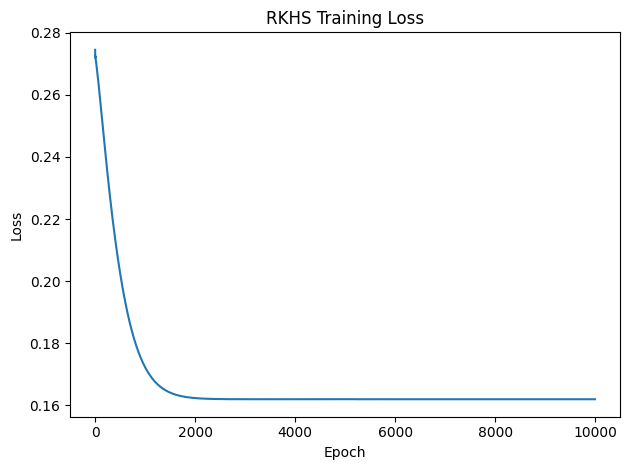

In [ ]:
# Plot training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RKHS Training Loss")
plt.tight_layout()
plt.show()

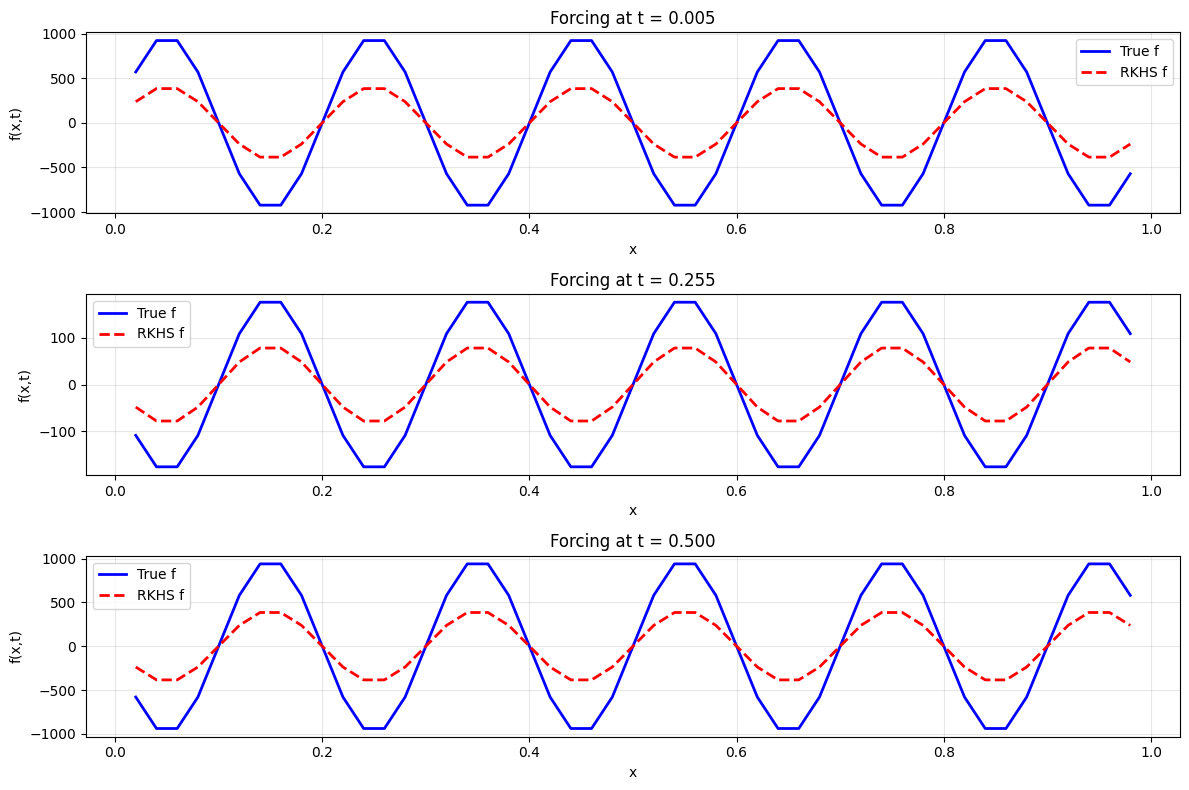

In [ ]:
# Visualize forcing functions
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot at different time slices
time_slices = [0, n_t//2, n_t-1]
for idx, t_idx in enumerate(time_slices):
    axes[idx].plot(x[1:-1], f_true[t_idx], 'b-', label='True f', linewidth=2)
    axes[idx].plot(x[1:-1], f_learned[t_idx], 'r--', label='RKHS f', linewidth=2)
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('f(x,t)')
    axes[idx].set_title(f'Forcing at t = {t[t_idx+1]:.3f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

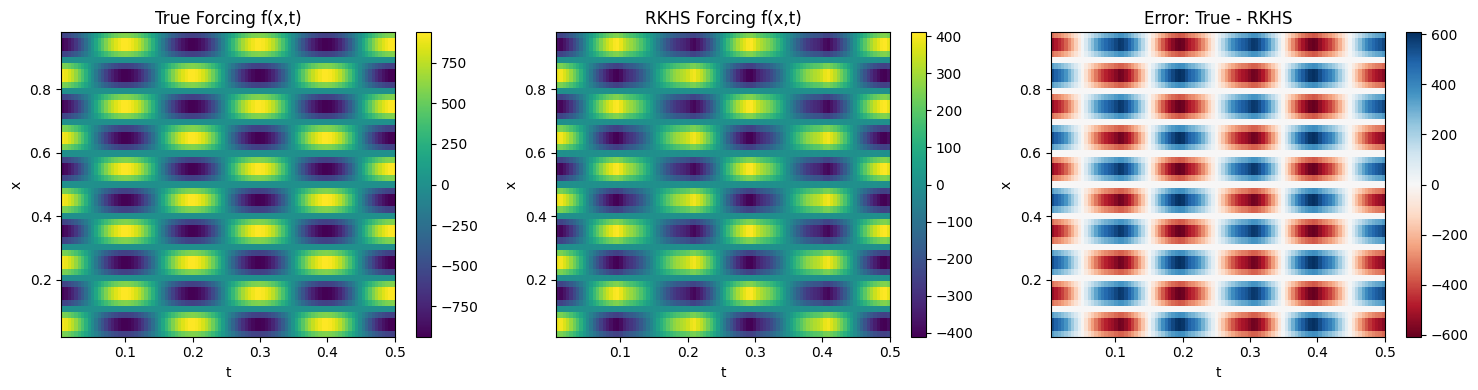

In [ ]:
# Heatmap comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))


im1 = axes[0].imshow(f_true.T, aspect='auto', cmap='viridis', origin='lower',
                     extent=[t[1], t[-1], x[1], x[-2]])
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
axes[0].set_title('True Forcing f(x,t)')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(f_learned.T, aspect='auto', cmap='viridis', origin='lower',
                     extent=[t[1], t[-1], x[1], x[-2]])
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
axes[1].set_title('RKHS Forcing f(x,t)')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow((f_true - f_learned).T, aspect='auto', cmap='RdBu', origin='lower',
                     extent=[t[1], t[-1], x[1], x[-2]])
axes[2].set_xlabel('t')
axes[2].set_ylabel('x')
axes[2].set_title('Error: True - RKHS')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

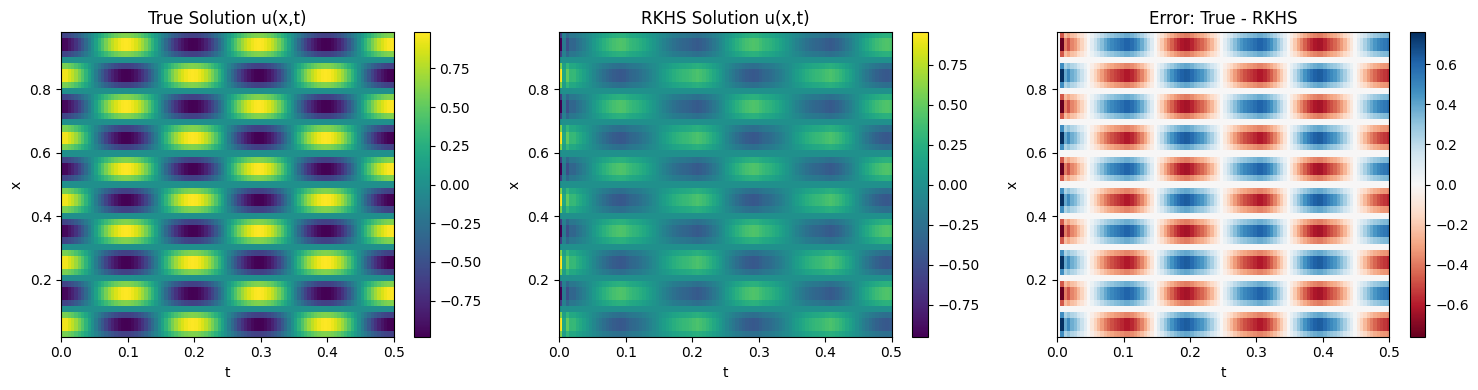

In [ ]:
# Compute and visualize solutions
f_full = f_learned
u_learned = time_stepping_1d(u0_true, f_full, A, k)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(u_traj_true.T, aspect='auto', cmap='viridis', origin='lower',
                     extent=[t[0], t[-1], x[1], x[-2]])
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
axes[0].set_title('True Solution u(x,t)')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(u_learned.T, aspect='auto', cmap='viridis', origin='lower',
                     extent=[t[0], t[-1], x[1], x[-2]])
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
axes[1].set_title('RKHS Solution u(x,t)')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow((u_traj_true - u_learned).T, aspect='auto', cmap='RdBu', origin='lower',
                     extent=[t[0], t[-1], x[1], x[-2]])
axes[2].set_xlabel('t')
axes[2].set_ylabel('x')
axes[2].set_title('Error: True - RKHS')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

In [ ]:
# Print final statistics
print(f"Final MSE (solution): {jnp.mean((u_traj_true - u_learned)**2):.6e}")
print(f"Final MSE (forcing):  {jnp.mean((f_true - f_learned)**2):.6e}")
print(f"RKHS norm:    {jnp.sqrt(alpha_trained @ K @ alpha_trained):.6f}")
print(f"Number of parameters: {n_train}")


FINAL RESULTS
Final MSE (solution): 9.718918e-02
Final MSE (forcing):  8.915101e+04
RKHS norm ||f||_H:    2544.572975
Number of parameters: 4900
